# 👻 Ghost on Local
---
[![Phantom](https://img.shields.io/badge/Version-2.0-teal.svg)]()
[![Phantom](https://img.shields.io/badge/Github-👻-black.svg)](https://github.com/Ming-doan/timeseries-imputation.git)

In [1]:
import pandas as pd
from modules.alias import get_by_aliases
from modules.utils.preprocessing import Preprocessing
from modules.utils.missing import CreateMissingDataFrame
from modules import Trainer
from modules.models import *
from modules.utils.callbacks import SavePlot, Combined
from modules.utils.generator import WindowGenerator
from modules.utils.cache import Cache

In [2]:
# Datasets
DATASET = 'data/hungyen_preprocessed'
SELECTED_COLUMNS = ['Waterlevel']
# Missing values
MISSING_PERCENTAGE = 4320
MISSING_GAPS = 1
SEED = 42
MODE = 'End' # 'Random', 'Linear', 'End'
# Models
WINDOW_SIZE = 2160
BATCH_SIZE = 64
MODELS = get_by_aliases(['rnn', 'lstm'])

### Preprocessing

In [3]:
import os
if not os.path.exists('results'):
    os.makedirs('results')

In [4]:
# Read CSV
df = pd.read_csv(f'{DATASET}.csv')
df = df[SELECTED_COLUMNS]

In [5]:
# Preprocessing data
preprocessing = Preprocessing()
df = preprocessing.flow(df)

In [6]:
# Create missing data
creator = CreateMissingDataFrame(df, MISSING_PERCENTAGE, MISSING_GAPS, split_mode=MODE, seed=SEED, is_constant_missing=True)

2023-11-05 03:01:42.444 | SUCCESS  | modules.utils.missing:__dropping_dataframe:165 - Dropped dataframe successfully. Missing indexs: [(59741, 64061)]


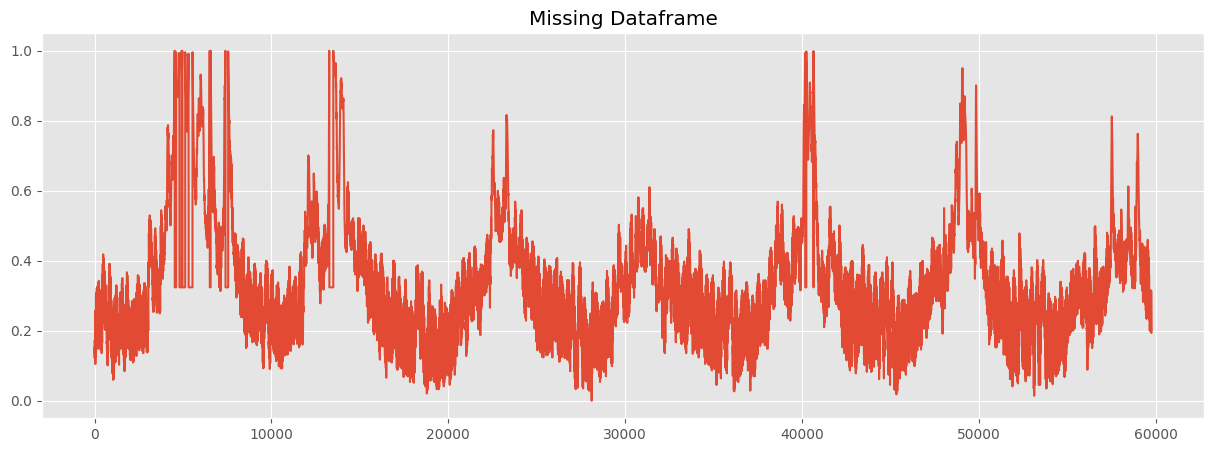

In [7]:
creator.plot(save_path='results/missing_data.png')

### Training

2023-11-05 03:01:42.783 | INFO     | modules.train:train:85 - Model 1/2: RNN
2023-11-05 03:01:42.784 | INFO     | modules.train:train:90 - Fitting the model RNN


RNN model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (64, 2160, 64)            4224      
                                                                 
 simple_rnn_1 (SimpleRNN)    (64, 32)                  3104      
                                                                 
 flatten (Flatten)           (64, 32)                  0         
                                                                 
 dense (Dense)               (64, 128)                 4224      
                                                                 
 dense_1 (Dense)             (64, 1)                   129       
                                                                 
Total params: 11681 (45.63 KB)
Trainable params: 11681 (45.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
E

2023-11-05 04:33:10.947 | INFO     | modules.train:train:116 - Training completed in 5488.16s


33/33 [==============================] - 4s 118ms/step


2023-11-05 04:33:15.102 | INFO     | modules.train:train:151 - Similarity on predicting: 0.9962357989046523


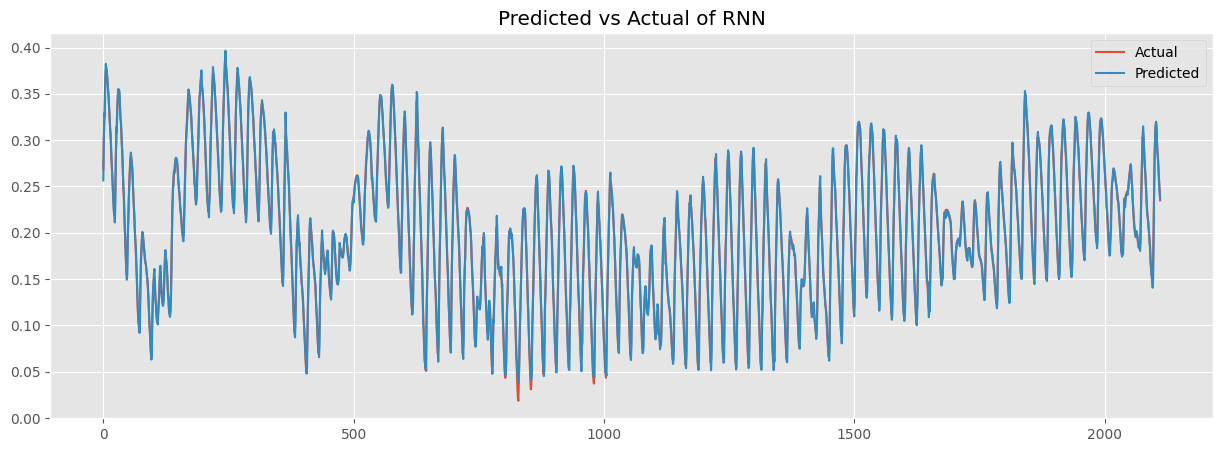

Forecasting: 100%|██████████| 120/120 [00:11<00:00, 10.37it/s]


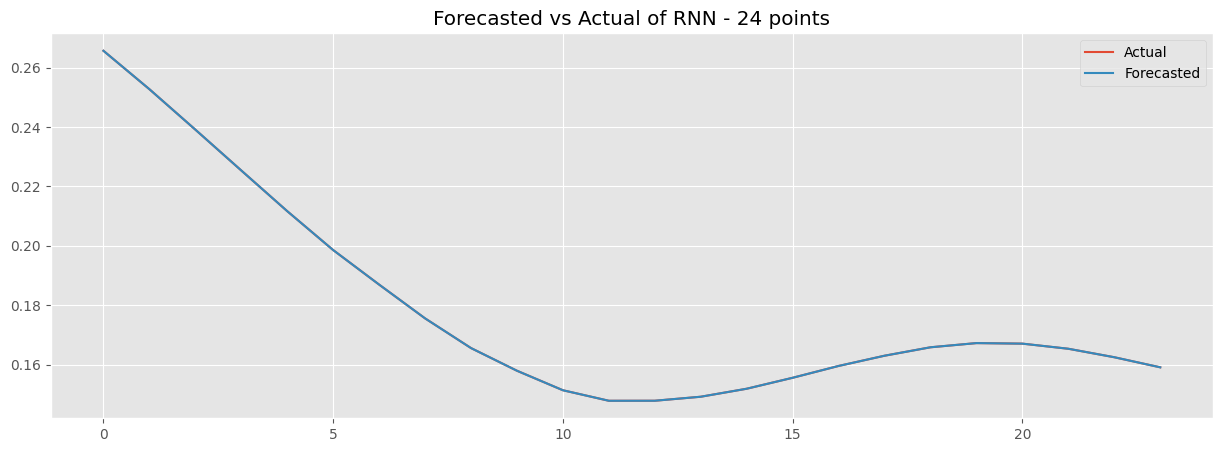

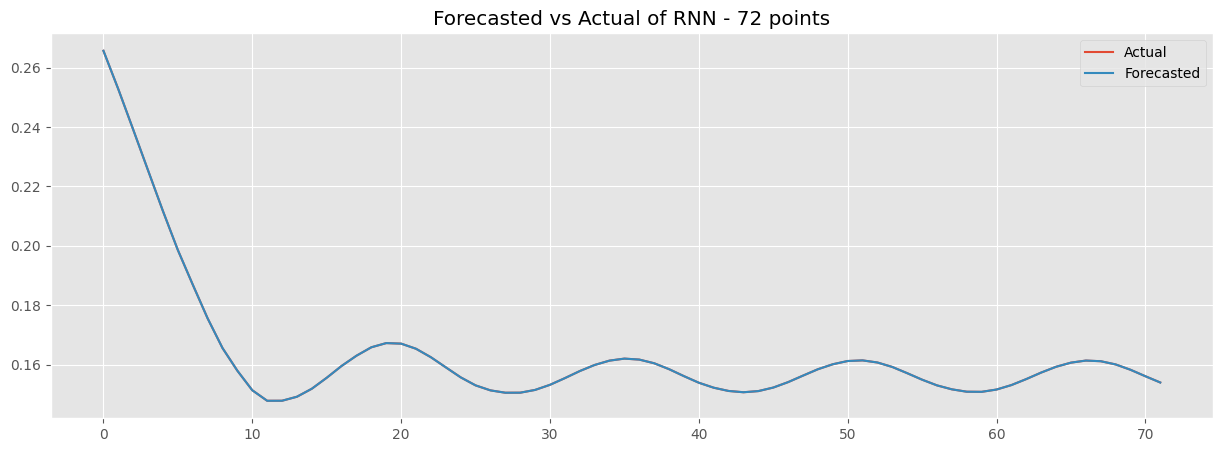

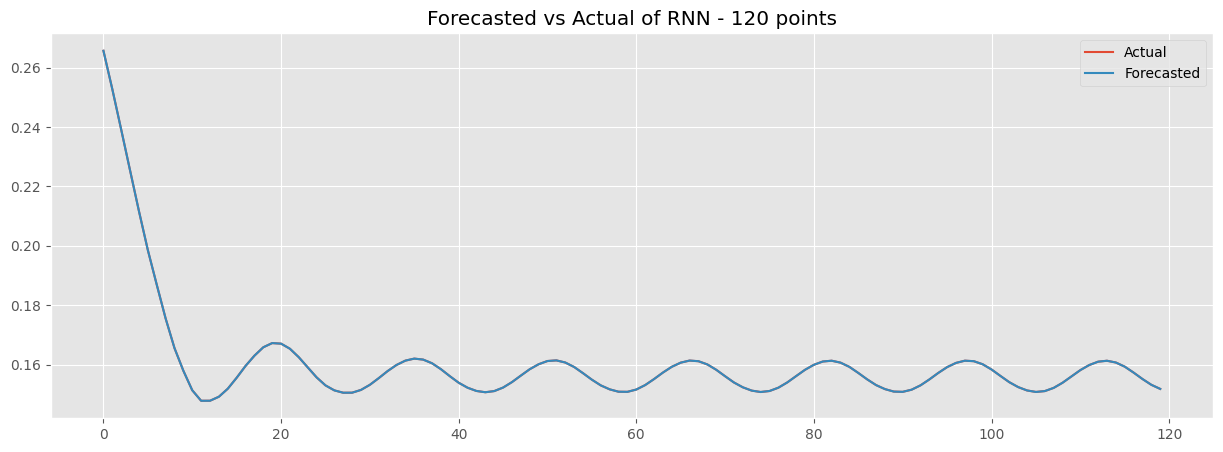

2023-11-05 04:33:36.926 | SUCCESS  | modules.train:train:182 - Model 1/2~RNN completed.
2023-11-05 04:33:36.926 | INFO     | modules.train:train:85 - Model 2/2: LSTM
2023-11-05 04:33:36.928 | INFO     | modules.train:train:90 - Fitting the model LSTM


LSTM model summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (64, 2160, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (64, 32)                  12416     
                                                                 
 flatten_1 (Flatten)         (64, 32)                  0         
                                                                 
 dense_2 (Dense)             (64, 128)                 4224      
                                                                 
 dense_3 (Dense)             (64, 1)                   129       
                                                                 
Total params: 33665 (131.50 KB)
Trainable params: 33665 (131.50 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________________________________________

2023-11-05 09:49:25.186 | INFO     | modules.train:train:116 - Training completed in 18948.26s


33/33 [==============================] - 13s 389ms/step


2023-11-05 09:49:38.292 | INFO     | modules.train:train:151 - Similarity on predicting: 0.9958330773853185


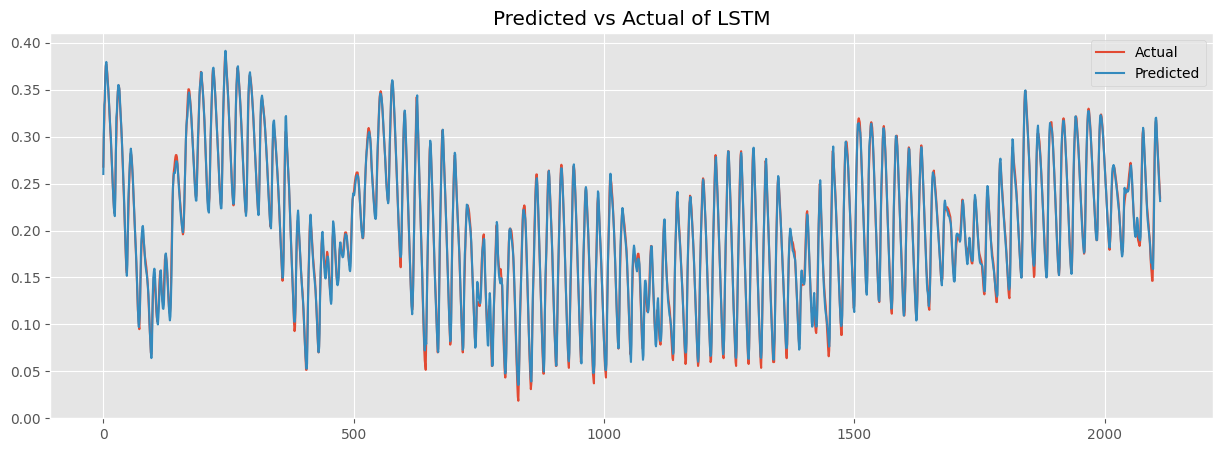

Forecasting: 100%|██████████| 120/120 [00:15<00:00,  7.52it/s]


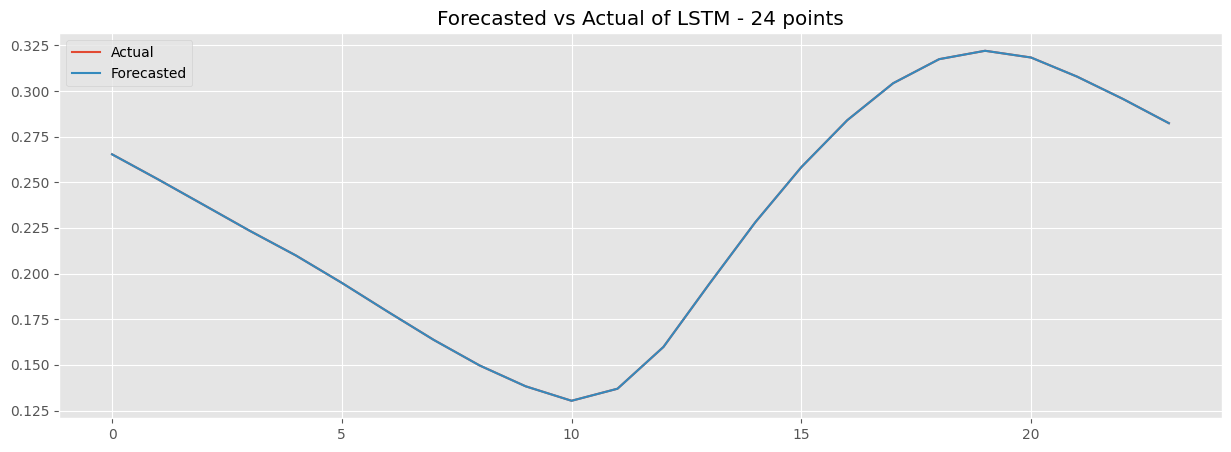

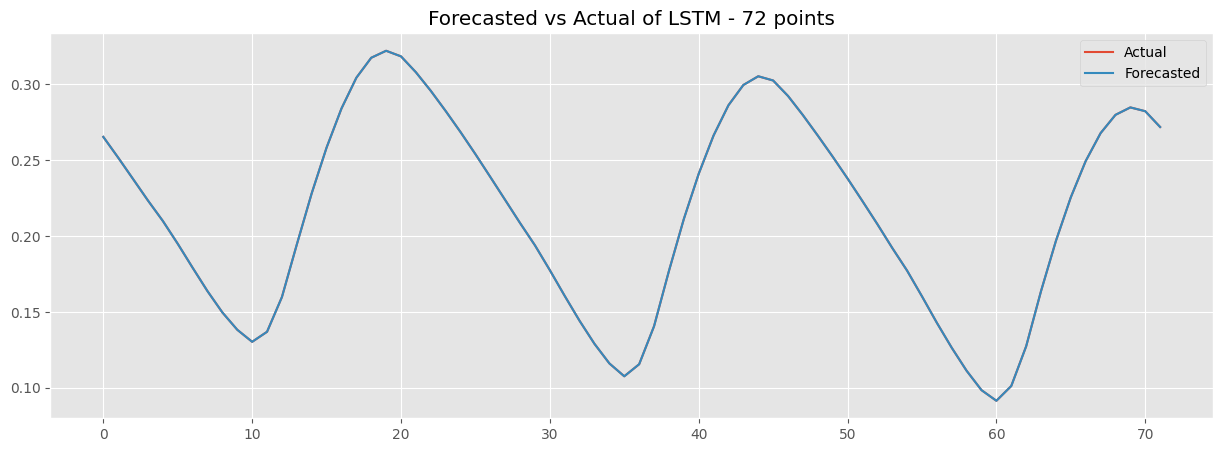

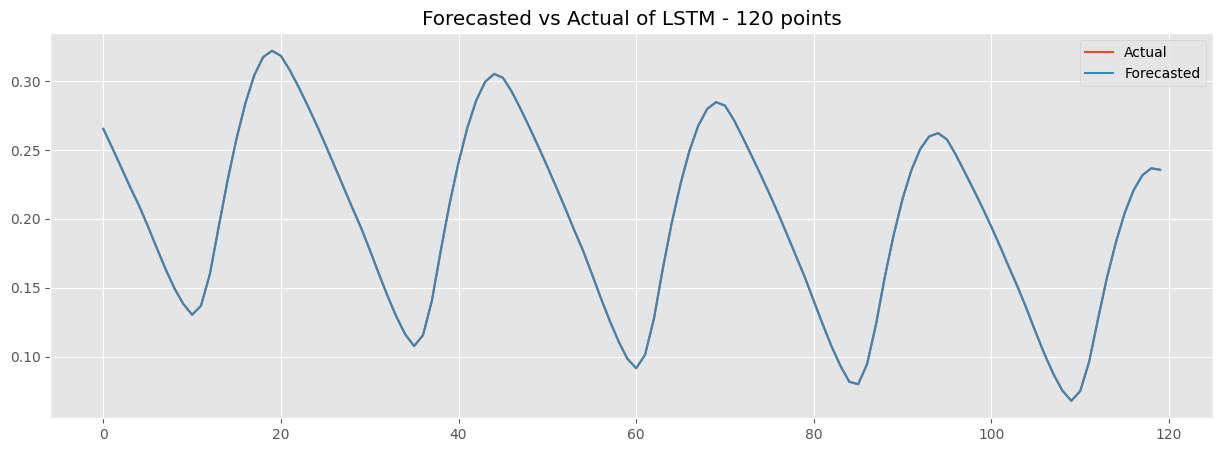

2023-11-05 09:50:08.254 | SUCCESS  | modules.train:train:182 - Model 2/2~LSTM completed.


In [8]:
# Training
trainer = Trainer(model=MODELS)
# combined_callback = Combined(n_models=len(MODELS), combination_mode='data_per', df=creator, save_directory="results")
sp = SavePlot(n_models=len(MODELS), save_directory="results")
cache = Cache(live_cache=True)

train_df, test_df = creator[0]

train_gen = WindowGenerator(train_df, WINDOW_SIZE, BATCH_SIZE)
test_gen = WindowGenerator(test_df, WINDOW_SIZE, BATCH_SIZE)

trainer.train(train_gen, test_gen, [24, 72, 120], callbacks=[sp], cache=cache)